In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [21]:
disease_types = ['Anthracnose','Downy_Mildew','Healthy','Mosaic_Virus']
data_dir = '../input/watermelon-dataset/Augmented_Image/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [22]:

train_data = []
for defects_id, sp in enumerate(disease_types):
   
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
    
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()


,File,DiseaseID,Disease Type
5770,Mosaic_Virus/IMG_2978_scaled.jpg,3,Mosaic_Virus
5771,Mosaic_Virus/IMG_3061_shifted.jpg,3,Mosaic_Virus
5772,Mosaic_Virus/IMG_2942_flip.jpg,3,Mosaic_Virus
5773,Mosaic_Virus/IMG_2169_flip.jpg,3,Mosaic_Virus
5774,Mosaic_Virus/IMG_3079_brightened.jpg,3,Mosaic_Virus


In [23]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Mosaic_Virus/IMG_2017_brightened.jpg,3,Mosaic_Virus
1,Downy_Mildew/IMG_3325_brightened.jpg,1,Downy_Mildew
2,Mosaic_Virus/IMG_2933_scaled.jpg,3,Mosaic_Virus
3,Mosaic_Virus/IMG_2973_flip.jpg,3,Mosaic_Virus
4,Anthracnose/IMG_4092_scaled.jpg,0,Anthracnose


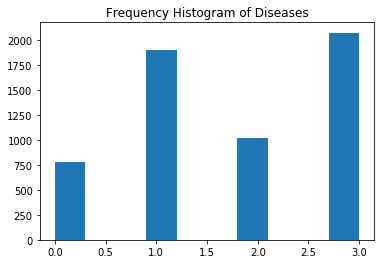

<Figure size 864x864 with 0 Axes>

In [24]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Diseases')
plt.figure(figsize=(12, 12))
plt.show()

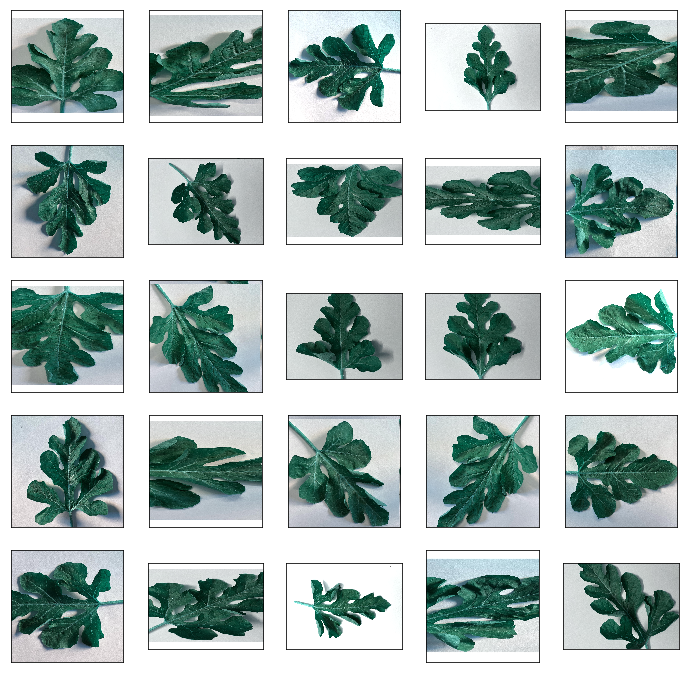

In [25]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Healthy', 5,5)

In [26]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [27]:
### Data processing

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

5775it [14:39,  6.57it/s]


Train Shape: (5775, 64, 64, 3)


In [28]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=4)

In [29]:

Y_train.shape

(5775, 4)

In [30]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

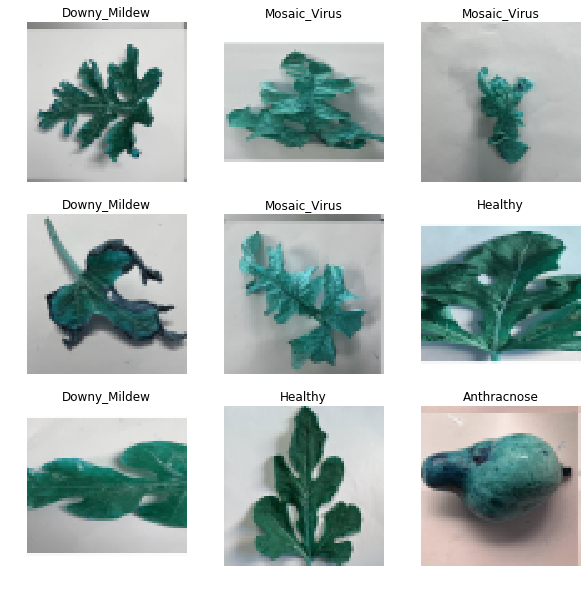

In [31]:
fig, ax = plt.subplots(3,3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i][j].set_axis_off()
        ax[i][j].imshow(X_train[i*3+j])
        ax[i][j].set_title(disease_types[np.argmax(Y_train[i*3+j])])

In [32]:
EPOCHS = 50
SIZE=64
N_ch=3

In [33]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(4,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [34]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2624

In [35]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

1155/1155 [==============================] - 1s 949us/step
Final Loss: 0.005495857687738071, Final Accuracy: 0.9982684254646301


Text(0.5, 144.41374999999996, 'Predicted')

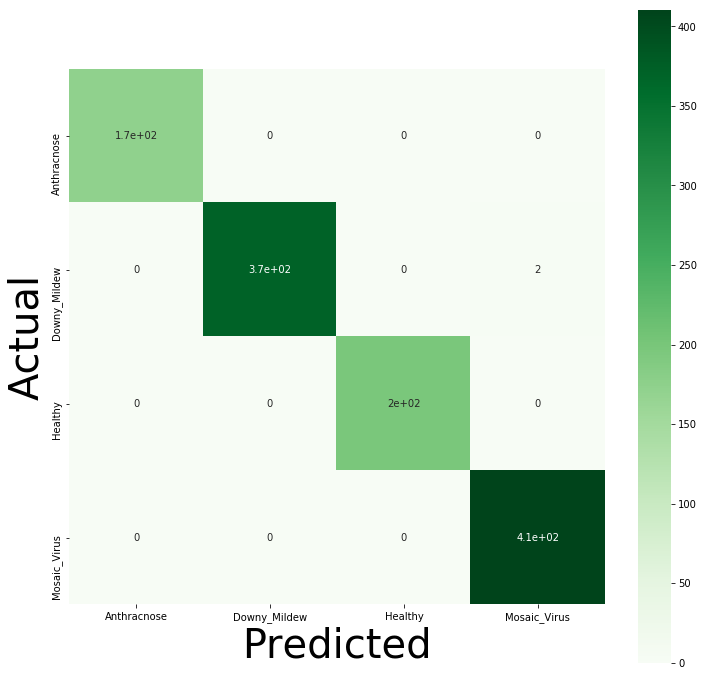

In [36]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

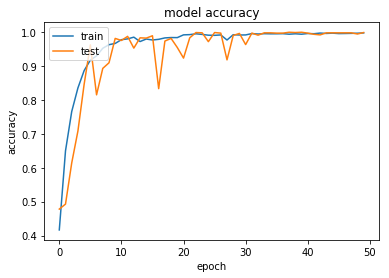

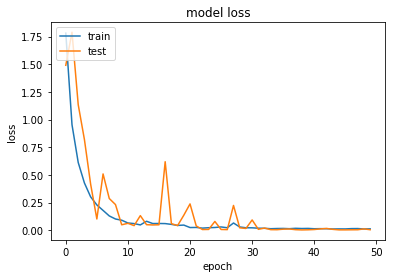

In [37]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Disease Prediction

In [38]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/kaggle/input/potatodataset/Potato/Potato___Early_blight/3d3c01e1-8cde-4c0f-9468-67dd287a2dc0___RS_Early.B 7761.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/kaggle/input/potatodataset/Potato/Potato___Early_blight/3d3c01e1-8cde-4c0f-9468-67dd287a2dc0___RS_Early.B 7761.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Potato___Early_blight','Potato___Late_blight','Potato___healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/potatodataset/Potato/Potato___Early_blight/3d3c01e1-8cde-4c0f-9468-67dd287a2dc0___RS_Early.B 7761.JPG'

# Production Version (Flask Web App) : [Plant Disease Diagnosis](https://github.com/shawon100/Plant-Disease-Diagnosis-Flask)